In [1]:
import numpy as np
import pandas as pd
import sklearn.preprocessing
import matplotlib.pyplot as plt
import gc

import sys
sys.path.append("..")
from helpers import filename_for

In [2]:
import tensorflow
from tensorflow import keras

print("tensorflow", tensorflow.__version__)
print("keras", keras.__version__)

tensorflow 2.3.1
keras 2.4.0


In [3]:
class DataGeneratorBars(keras.utils.Sequence):
    def __init__(self, config):
        self.c = config

        self.labels = []
        self.features = []

        self.scaler_tri = sklearn.preprocessing.MaxAbsScaler()
        self.scaler_e = sklearn.preprocessing.MaxAbsScaler()
        self.scaler_t = sklearn.preprocessing.MaxAbsScaler()

        file = filename_for(
            self.c["distance"],
            self.c["doubleplane"],
            self.c["energy"],
            self.c["erel"],
            self.c["neutrons"][0],
            "inclxx",
            self.c["subruns"][0],
            "bars.parquet",
        )
        data = pd.read_parquet(file)
        rows = len(data.index)
        del data

        self.batches_per_subrun = (rows * len(self.c["neutrons"])) // self.c["batch_size"]
        self.batches_per_cache = self.batches_per_subrun * self.c["subrun_cache_size"]
        self.len = self.batches_per_subrun * len(self.c["subruns"])

        self.cache_subruns = [
            self.c["subruns"][i : i + self.c["subrun_cache_size"]]
            for i in range(0, len(self.c["subruns"]), self.c["subrun_cache_size"])
        ]
        self.current_cache = -1

        print(f"Rows in one file: {rows}")
        print(f"{self.batches_per_subrun} batches per subrun")
        print(f"{self.len} total batches in {self.cache_subruns} caches")

        self.fitscalers()
        self.load(0)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        cacheid = index // self.batches_per_cache
        i = index % (self.batches_per_cache)
        # print(f"{index} -> c{cacheid}-i{i}")

        if cacheid != self.current_cache:
            self.load(cacheid)

        a = i * self.c["batch_size"]
        b = (i + 1) * self.c["batch_size"]

        x = self.features[a:b]
        y = self.labels[a:b]
        return x, y

    def load(self, cacheid):
        subruns = self.cache_subruns[cacheid]
        print(f"Loading subruns {subruns} for cache {cacheid}")

        files = [
            filename_for(
                self.c["distance"],
                self.c["doubleplane"],
                self.c["energy"],
                self.c["erel"],
                n,
                "inclxx",
                subrun,
                "bars.parquet",
            )
            for n in self.c["neutrons"]
            for subrun in subruns
        ]
        data = pd.concat([pd.read_parquet(file) for file in files], ignore_index=True).sample(frac=1)
        data.loc[data["nHits"] == 0, self.c["label"]] = 0

        self.current_cache = cacheid
        self.features = np.concatenate(
            (
                self.scaler_tri.transform(data[self.c["cols_tri"]]),
                self.scaler_e.transform(data[self.c["cols_e"]].values.reshape(-1, 1)).reshape(
                    -1, len(self.c["cols_e"])
                ),
                self.scaler_t.transform(data[self.c["cols_t"]].values.reshape(-1, 1)).reshape(
                    -1, len(self.c["cols_t"])
                ),
            ),
            axis=1,
        )
        self.labels = keras.utils.to_categorical(
            data[[self.c["label"]]].values.ravel(), num_classes=len(self.c["neutrons"]) + 1
        )
        del data

    def fitscalers(self):
        subruns = range(5)  # self.cache_subruns[0]
        files = [
            filename_for(
                self.c["distance"],
                self.c["doubleplane"],
                self.c["energy"],
                self.c["erel"],
                n,
                "inclxx",
                subrun,
                "bars.parquet",
            )
            for n in self.c["neutrons"]
            for subrun in subruns
        ]
        data = pd.concat([pd.read_parquet(file) for file in files], ignore_index=True)
        self.scaler_tri.fit(data[self.c["cols_tri"]])
        self.scaler_e.fit(data[self.c["cols_e"]].values.reshape(-1, 1))
        self.scaler_t.fit(data[self.c["cols_t"]].values.reshape(-1, 1))
        del data

In [4]:
config = {
    "distance": 15,
    "doubleplane": 30,
    "energy": 600,
    "erel": 500,
    "neutrons": [1, 2, 3, 4],
    "subruns": range(6),  # range(19),
    "subrun_cache_size": 6,
    "batch_size": 100,
    "cols_tri": ["nHits", "nClus", "Edep"],
    "cols_e": [str(i) for i in range(0, 30 * 100 * 2, 2)],
    "cols_t": [str(i + 1) for i in range(0, 30 * 100 * 2, 2)],
    "label": "nPN",
}

validation_config = config.copy()
validation_config["subruns"] = [19]

In [5]:
generator = DataGeneratorBars(config)
validation_generator = DataGeneratorBars(validation_config)

Rows in one file: 10000
400 batches per subrun
2400 total batches in [range(0, 6)] caches
Loading subruns range(0, 6) for cache 0
Rows in one file: 10000
400 batches per subrun
400 total batches in [[19]] caches
Loading subruns [19] for cache 0


0

In [6]:
model1 = keras.models.Sequential()
model1.add(keras.layers.Dense(units=len(config["neutrons"]) + 1, activation="softmax"))

loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam()
model1.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
history1 = model1.fit(generator, verbose=2, epochs=10, shuffle=True, validation_data=validation_generator)

Epoch 1/10
2400/2400 - 17s - loss: 1.2034 - accuracy: 0.5108 - val_loss: 1.0320 - val_accuracy: 0.6292
Epoch 2/10
2400/2400 - 7s - loss: 0.9626 - accuracy: 0.6488 - val_loss: 0.9121 - val_accuracy: 0.6639
Epoch 3/10
2400/2400 - 8s - loss: 0.8757 - accuracy: 0.6690 - val_loss: 0.8491 - val_accuracy: 0.6740
Epoch 4/10
2400/2400 - 7s - loss: 0.8239 - accuracy: 0.6781 - val_loss: 0.8080 - val_accuracy: 0.6801
Epoch 5/10
2400/2400 - 7s - loss: 0.7886 - accuracy: 0.6837 - val_loss: 0.7794 - val_accuracy: 0.6834
Epoch 6/10
2400/2400 - 7s - loss: 0.7634 - accuracy: 0.6881 - val_loss: 0.7588 - val_accuracy: 0.6864
Epoch 7/10
2400/2400 - 7s - loss: 0.7448 - accuracy: 0.6910 - val_loss: 0.7436 - val_accuracy: 0.6877
Epoch 8/10
2400/2400 - 7s - loss: 0.7308 - accuracy: 0.6932 - val_loss: 0.7321 - val_accuracy: 0.6893
Epoch 9/10
2400/2400 - 7s - loss: 0.7199 - accuracy: 0.6949 - val_loss: 0.7231 - val_accuracy: 0.6916
Epoch 10/10
2400/2400 - 7s - loss: 0.7112 - accuracy: 0.6965 - val_loss: 0.7158 -

In [7]:
model2 = keras.models.Sequential()
model2.add(keras.layers.Dense(units=10, activation="relu"))
model2.add(keras.layers.Dense(units=len(config["neutrons"]) + 1, activation="softmax"))

loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam()
model2.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
history2 = model2.fit(generator, verbose=2, epochs=10, shuffle=True, validation_data=validation_generator)

Epoch 1/10
2400/2400 - 7s - loss: 0.9198 - accuracy: 0.6190 - val_loss: 0.7335 - val_accuracy: 0.6981
Epoch 2/10
2400/2400 - 7s - loss: 0.6970 - accuracy: 0.7007 - val_loss: 0.6719 - val_accuracy: 0.7073
Epoch 3/10
2400/2400 - 7s - loss: 0.6562 - accuracy: 0.7188 - val_loss: 0.6542 - val_accuracy: 0.7218
Epoch 4/10
2400/2400 - 7s - loss: 0.6415 - accuracy: 0.7240 - val_loss: 0.6453 - val_accuracy: 0.7214
Epoch 5/10
2400/2400 - 7s - loss: 0.6326 - accuracy: 0.7264 - val_loss: 0.6409 - val_accuracy: 0.7188
Epoch 6/10
2400/2400 - 7s - loss: 0.6267 - accuracy: 0.7282 - val_loss: 0.6375 - val_accuracy: 0.7238
Epoch 7/10
2400/2400 - 7s - loss: 0.6222 - accuracy: 0.7295 - val_loss: 0.6363 - val_accuracy: 0.7229
Epoch 8/10
2400/2400 - 7s - loss: 0.6187 - accuracy: 0.7304 - val_loss: 0.6348 - val_accuracy: 0.7247
Epoch 9/10
2400/2400 - 7s - loss: 0.6157 - accuracy: 0.7319 - val_loss: 0.6344 - val_accuracy: 0.7235
Epoch 10/10
2400/2400 - 7s - loss: 0.6130 - accuracy: 0.7333 - val_loss: 0.6331 - 

In [8]:
model3 = keras.models.Sequential()
model3.add(keras.layers.Dense(units=100, activation="relu"))
model3.add(keras.layers.Dense(units=len(config["neutrons"]) + 1, activation="softmax"))

loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam()
model3.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
history3 = model3.fit(generator, verbose=2, epochs=10, shuffle=True, validation_data=validation_generator)

Epoch 1/10
2400/2400 - 8s - loss: 0.7591 - accuracy: 0.6759 - val_loss: 0.6532 - val_accuracy: 0.7240
Epoch 2/10
2400/2400 - 7s - loss: 0.6353 - accuracy: 0.7270 - val_loss: 0.6331 - val_accuracy: 0.7229
Epoch 3/10
2400/2400 - 8s - loss: 0.6160 - accuracy: 0.7324 - val_loss: 0.6265 - val_accuracy: 0.7254
Epoch 4/10
2400/2400 - 8s - loss: 0.6047 - accuracy: 0.7378 - val_loss: 0.6245 - val_accuracy: 0.7279
Epoch 5/10
2400/2400 - 8s - loss: 0.5953 - accuracy: 0.7421 - val_loss: 0.6279 - val_accuracy: 0.7250
Epoch 6/10
2400/2400 - 8s - loss: 0.5844 - accuracy: 0.7472 - val_loss: 0.6267 - val_accuracy: 0.7246
Epoch 7/10
2400/2400 - 8s - loss: 0.5722 - accuracy: 0.7537 - val_loss: 0.6274 - val_accuracy: 0.7276
Epoch 8/10
2400/2400 - 8s - loss: 0.5585 - accuracy: 0.7604 - val_loss: 0.6341 - val_accuracy: 0.7219
Epoch 9/10
2400/2400 - 9s - loss: 0.5440 - accuracy: 0.7687 - val_loss: 0.6415 - val_accuracy: 0.7206
Epoch 10/10
2400/2400 - 8s - loss: 0.5297 - accuracy: 0.7764 - val_loss: 0.6475 - 

In [9]:
model4 = keras.models.Sequential()
model4.add(keras.layers.Dense(units=1000, activation="relu"))
model4.add(keras.layers.Dense(units=100, activation="relu"))
model4.add(keras.layers.Dense(units=len(config["neutrons"]) + 1, activation="softmax"))

loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam()
model4.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
history4 = model4.fit(generator, verbose=2, epochs=10, shuffle=True, validation_data=validation_generator)

Epoch 1/10
2400/2400 - 12s - loss: 0.6672 - accuracy: 0.7084 - val_loss: 0.6239 - val_accuracy: 0.7290
Epoch 2/10
2400/2400 - 12s - loss: 0.6140 - accuracy: 0.7307 - val_loss: 0.6325 - val_accuracy: 0.7271
Epoch 3/10
2400/2400 - 12s - loss: 0.5840 - accuracy: 0.7436 - val_loss: 0.6171 - val_accuracy: 0.7335
Epoch 4/10
2400/2400 - 12s - loss: 0.5296 - accuracy: 0.7715 - val_loss: 0.6466 - val_accuracy: 0.7218
Epoch 5/10
2400/2400 - 12s - loss: 0.4281 - accuracy: 0.8236 - val_loss: 0.7258 - val_accuracy: 0.7113
Epoch 6/10
2400/2400 - 12s - loss: 0.2976 - accuracy: 0.8859 - val_loss: 0.9255 - val_accuracy: 0.6942
Epoch 7/10
2400/2400 - 12s - loss: 0.1853 - accuracy: 0.9329 - val_loss: 1.2001 - val_accuracy: 0.6848
Epoch 8/10
2400/2400 - 12s - loss: 0.1147 - accuracy: 0.9600 - val_loss: 1.5329 - val_accuracy: 0.6828
Epoch 9/10
2400/2400 - 12s - loss: 0.0797 - accuracy: 0.9730 - val_loss: 1.7210 - val_accuracy: 0.6700
Epoch 10/10
2400/2400 - 12s - loss: 0.0581 - accuracy: 0.9807 - val_loss:

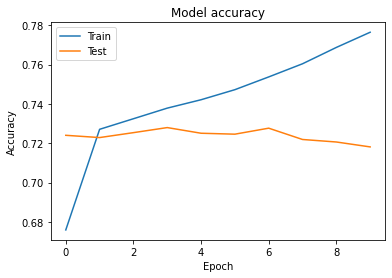

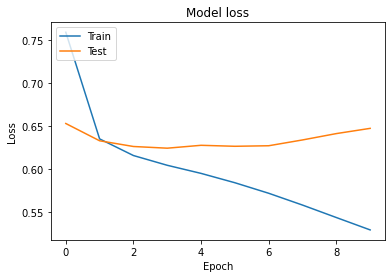

In [10]:
# Plot training & validation accuracy values
plt.plot(history3.history["accuracy"])
plt.plot(history3.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history3.history["loss"])
plt.plot(history3.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [11]:
del generator
del validation_generator
gc.collect()

5848

In [12]:
test_config = config.copy()
test_config["subruns"] = range(14, 16)
test_generator = DataGeneratorBars(test_config)

Rows in one file: 10000
400 batches per subrun
800 total batches in [range(14, 16)] caches
Loading subruns range(14, 16) for cache 0


In [13]:
X = test_generator.features
y_true = np.argmax(test_generator.labels, axis=1)

In [14]:
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

for model in [model1, model2, model3, model4]:
    y_pred = np.argmax(model.predict(X), axis=1)
    bac = balanced_accuracy_score(y_true, y_pred)
    print(bac)
    cm = confusion_matrix(y_true, y_pred, labels=range(0, len(config["neutrons"]) + 1))
    print(cm)
    cmrel = confusion_matrix(y_true, y_pred, labels=range(0, len(config["neutrons"]) + 1), normalize="true")
    print((cmrel * 100).round())

0.5592676127997407
[[    0  1053     0     0     0]
 [    0 17101  1882     8     3]
 [    0  3410 12418  4087    40]
 [    0   436  3901 10187  5474]
 [    0    41   715  3958 15286]]
[[  0. 100.   0.   0.   0.]
 [  0.  90.  10.   0.   0.]
 [  0.  17.  62.  20.   0.]
 [  0.   2.  20.  51.  27.]
 [  0.   0.   4.  20.  76.]]
0.7767721550179151
[[ 1053     0     0     0     0]
 [  102 17615  1265     7     5]
 [   14  3372 13378  3182     9]
 [    1   427  4076 10845  4649]
 [    1    43   755  4326 14875]]
[[100.   0.   0.   0.   0.]
 [  1.  93.   7.   0.   0.]
 [  0.  17.  67.  16.   0.]
 [  0.   2.  20.  54.  23.]
 [  0.   0.   4.  22.  74.]]
0.7741234867933791
[[ 1053     0     0     0     0]
 [    0 17747  1231    10     6]
 [    0  3515 14348  2041    51]
 [    0   448  5140 10390  4020]
 [    0    53  1024  4969 13954]]
[[100.   0.   0.   0.   0.]
 [  0.  93.   6.   0.   0.]
 [  0.  18.  72.  10.   0.]
 [  0.   2.  26.  52.  20.]
 [  0.   0.   5.  25.  70.]]
0.7351447918636682
[[ 